# 03/11/21 - This notebook uses the G3CGal GAMA DR3 group catalog to study the group properties of the candidates.

In [11]:
# libraries

from pyprojroot import here
print(f'You are here: {here()}')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats

%matplotlib inline

from astropy import constants as const
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value

c = const.c.to('km/s').value #c in km/s
h0 = 73.8 #h0 in km/(Mpc*s) Riess2011
cosmo = FlatLambdaCDM(h0, Om0=0.262)

# paths
autoz_path = f'{here()}/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
latest_path = f'{csv_path}latest/'
visual_path = f'{autoz_path}visuals/'
png_path = f'{visual_path}png/'
pdf_path = f'{visual_path}pdf/'
knabel2020_file_path = '/data/sknabel/lens_methods/files/'

You are here: /data/sknabel/autoz_lens_model


In [50]:
# import candidate samples
links = pd.read_csv(f'{latest_path}links_sample_latest.csv')
#links_knabel = pd.read_csv(f'{latest_path}links_knabel_sample_latest_len6.csv')
li = pd.read_csv(f'{latest_path}li_sample_latest.csv')

candidates = pd.concat([links, li])

#print(len(links), len(li))
print(len(candidates))
print(candidates.columns)
print(candidates.head())

42
Index(['Unnamed: 0', 'Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA', 'DEC', 'score',
       'Unnamed: 0_y', 'z1', 'sigma1', 'template1', 'z2', 'sigma2',
       'template2', 'sigma3', 'sigma4', 'R', 'prob', 'error', 'type',
       'type_number', 'lambdar_log_mstar', 'lambdar_mstar',
       'lambdar_log_mstar_error', 'z', 'zlens', 'zsource', 'sigma_lens',
       'sigma_source', 'dlens', 'dsource', 'corrected_stellar_mass', 'P1',
       'P3', 'normalized_score', 'cnn_probability', 'm_half_re', 'sigma_star',
       'theta_e_pm', 'theta_e_sis', 'KIDS_ID', 'mag', 'mag_err', 'name',
       'num_0', 'probability', 'rms', 's*p/10', 'z_max', 'z_min', 'zphot'],
      dtype='object')
   Unnamed: 0  Unnamed: 0_x    GAMA_ID      ID         RA      DEC  score  \
0           0            30   600305.0   245.0  134.75916  0.23814   12.0   
1           1            51   419067.0  1179.0  138.61974  2.63477    8.0   
2           2           115   387244.0  1819.0  135.56917  2.36495    4.0   
3           3    

In [60]:
# load G3CGal.fits
group_catalog = fits.open(f'{fits_path}G3CGal.fits')[1].data
group_byte_swap=group_catalog.byteswap().newbyteorder()
groups = pd.DataFrame(group_byte_swap[:])#, columns = group_catalog.columns.names)

groups.rename(columns={'CATAID':'GAMA_ID', 'Dec':'DEC'}, inplace=True)

print(groups.columns)
print(len(group))

print(groups.head())

print(group_byte_swap[:5])

Index(['GAMA_ID', 'RA', 'DEC', 'Z', 'Rpetro', 'DM_100_25_75', 'SURVEY_CODE',
       'SigErr', 'GroupID', 'RankIterCen', 'SepIterCen', 'CoSepIterCen',
       'AngSepIterCen', 'RankBCG', 'SepBCG', 'CoSepBCG', 'AngSepBCG',
       'RankCen', 'SepCen', 'CoSepCen', 'AngSepCen'],
      dtype='object')
82073
   GAMA_ID          RA       DEC         Z     Rpetro  DM_100_25_75  \
0    14450  211.540124  0.631347  0.267499  18.163097     39.916611   
1    14455  211.563256  0.755024  0.126964  18.976887     38.107971   
2    14460  211.523649  0.635051  0.032301  18.318932     34.985935   
3    14464  211.516067  0.642177  0.448039  19.796221     41.236923   
4    14465  211.559731  0.791372  0.199598  19.536310     39.193077   

   SURVEY_CODE     SigErr  GroupID  RankIterCen  SepIterCen  CoSepIterCen  \
0            1  13.703888        0         -999      -999.0        -999.0   
1            5  25.838869        0         -999      -999.0        -999.0   
2            5  26.449982        0      

In [101]:
# merge candidates with group
candidates_groups = pd.merge(candidates, groups, how='left', on='GAMA_ID')
print(candidates_groups.columns)
candidates_groups[['GAMA_ID','ID','score','lambdar_log_mstar','GroupID', 'RA_x', 'RA_y']].sort_values(by=['score'], ascending=False)

Index(['Unnamed: 0', 'Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA_x', 'DEC_x', 'score',
       'Unnamed: 0_y', 'z1', 'sigma1', 'template1', 'z2', 'sigma2',
       'template2', 'sigma3', 'sigma4', 'R', 'prob', 'error', 'type',
       'type_number', 'lambdar_log_mstar', 'lambdar_mstar',
       'lambdar_log_mstar_error', 'z', 'zlens', 'zsource', 'sigma_lens',
       'sigma_source', 'dlens', 'dsource', 'corrected_stellar_mass', 'P1',
       'P3', 'normalized_score', 'cnn_probability', 'm_half_re', 'sigma_star',
       'theta_e_pm', 'theta_e_sis', 'KIDS_ID', 'mag', 'mag_err', 'name',
       'num_0', 'probability', 'rms', 's*p/10', 'z_max', 'z_min', 'zphot',
       'RA_y', 'DEC_y', 'Z', 'Rpetro', 'DM_100_25_75', 'SURVEY_CODE', 'SigErr',
       'GroupID', 'RankIterCen', 'SepIterCen', 'CoSepIterCen', 'AngSepIterCen',
       'RankBCG', 'SepBCG', 'CoSepBCG', 'AngSepBCG', 'RankCen', 'SepCen',
       'CoSepCen', 'AngSepCen'],
      dtype='object')


,GAMA_ID,ID,score,lambdar_log_mstar,GroupID,RA_x,RA_y
18,323152.0,2967.0,30.0,NaN,NaN,130.546430,NaN
17,250289.0,2730.0,28.0,11.668818,304825.0,214.367080,214.367059
31,3629152.0,1933.0,26.0,11.630485,NaN,135.888640,NaN
19,3575500.0,1906.0,26.0,11.760890,NaN,129.232650,NaN
5,585328.0,3234.0,18.0,11.414567,NaN,182.368380,NaN
11,544226.0,3212.0,18.0,11.285226,0.0,214.423360,214.423354
32,3891172.0,3056.0,16.0,11.422040,NaN,139.227250,NaN
27,138582.0,2828.0,14.0,11.563930,NaN,183.140090,NaN
0,600305.0,245.0,12.0,11.614862,NaN,134.759160,NaN
34,262874.0,26.0,12.0,11.252039,0.0,221.610670,221.610700


In [102]:
# number of candidates with no group metric - 23
len(candidates_groups[candidates_groups.GroupID.isnull()])

23

In [105]:
candidates_with_groups = candidates_groups[candidates_groups.GroupID.notnull()]
#candidates_with_groups.reset_index()
#candidates_with_groups.drop(columns={'Unnamed: 0','Unnamed: 0_x'}, inplace=True)
candidates_with_groups[['GAMA_ID','ID','score','zlens','lambdar_log_mstar','GroupID', 'RA_x', 'RA_y']].sort_values(by=['score'], ascending=False)

,GAMA_ID,ID,score,zlens,lambdar_log_mstar,GroupID,RA_x,RA_y
17,250289.0,2730.0,28.0,0.401214,11.668818,304825.0,214.367080,214.367059
11,544226.0,3212.0,18.0,0.227044,11.285226,0.0,214.423360,214.423354
34,262874.0,26.0,12.0,0.385581,11.252039,0.0,221.610670,221.610700
36,77312.0,2749.0,8.0,0.372997,11.508821,301693.0,212.845280,212.845196
35,296451.0,2635.0,8.0,0.444535,11.861844,301069.0,211.853990,211.853981
12,62734.0,539.0,8.0,0.274168,11.506654,303503.0,213.562060,213.562066
41,569641.0,NaN,4.6,0.359714,11.636249,307498.0,219.729690,219.729688
24,262836.0,1953.0,4.0,0.144270,11.660450,0.0,221.405360,221.405358
25,318892.0,985.0,4.0,0.071459,11.633840,0.0,212.777470,212.777406
16,342310.0,2163.0,4.0,0.379751,11.405825,300672.0,215.081010,215.080971


In [106]:
# split between isos and groups is 10-9
isos = candidates_with_groups[candidates_with_groups.GroupID == 0.0]
groups = candidates_with_groups[candidates_with_groups.GroupID != 0.0]
print(len(isos), len(groups))

10 9


/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:836: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:836: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:836: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/soft/anaconda3/lib/python3.7/s

(0.0, 0.625)

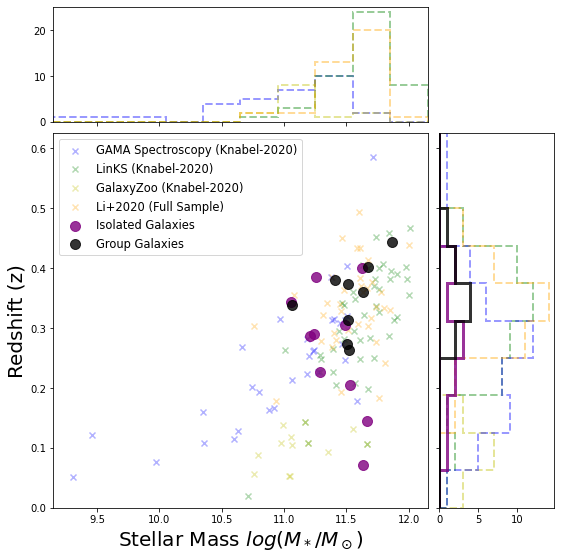

In [119]:
# pull datasets from Knabel-2020
spec = pd.read_csv(f'{knabel2020_file_path}spec_lambdar_revisions_063020.csv')
mac = pd.read_csv(f'{knabel2020_file_path}mac_lambdar_revisions_063020.csv')
zoo = pd.read_csv(f'{knabel2020_file_path}zoo_lambdar_revisions_063020.csv')
li_full = pd.read_csv(f'{knabel2020_file_path}li_lambdar.csv')

# Three-panel plot
from matplotlib.ticker import NullFormatter
nullfmt   = NullFormatter()         # no labels
# definitions for the axes
left, width = 0.1, 0.65
lower, height = 0.1, 0.65
lower_h = left_h = left+width+0.02
    
rect_scatter = [left, lower, width, height]
rect_histx = [left, lower_h, width, 0.2]
rect_histy = [left_h, lower, 0.2, height]
    
    # start with a rectangular Figure
plt.figure(1, figsize=(8,8))
    
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)
    
    # no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)


# knabel2020 data
axScatter.scatter(spec.lambdar_log_mstar, spec.z_lens, 
               marker='x', color='b', alpha = 0.3, label='GAMA Spectroscopy (Knabel-2020)')
axScatter.scatter(mac.lambdar_log_mstar, mac.z, 
               marker='x', color='g', alpha = 0.3, label='LinKS (Knabel-2020)')
axScatter.scatter(zoo.lambdar_log_mstar, zoo.z, 
               marker='x', color='y', alpha = 0.3, label='GalaxyZoo (Knabel-2020)')
axScatter.scatter(li_full.lambdar_log_mstar, li_full.z, 
               marker='x', color='orange', alpha = 0.3, label='Li+2020 (Full Sample)')

# autoz data
#axScatter.scatter(links.lambdar_log_mstar, links.zlens, 
#               marker='o',color='k', alpha = 0.8, label='LinKS AUTOZ Sample')
#axScatter.scatter(links_knabel.lambdar_log_mstar, links_knabel.zlens, 
#               marker='o',color='g', alpha = 0.8, label='LinKS (Knabel-2020) AUTOZ Sample')
#axScatter.scatter(li.lambdar_log_mstar, li.zlens, 
#               marker='o', color='orange', alpha = 0.8, label='Li+2020 AUTOZ Sample')

#group data
axScatter.scatter(isos.lambdar_log_mstar, isos.zlens, 
               marker='o',color='purple', s=100, alpha = 0.8, label='Isolated Galaxies')
axScatter.scatter(groups.lambdar_log_mstar, groups.zlens, 
               marker='o',color='k', s=100, alpha = 0.8, label='Group Galaxies')

axScatter.legend(loc='upper left', numpoints=1, fontsize = 11.5)

axScatter.axis([9.15,12.15,0.,0.625])#, prop={'size':25})

axScatter.set_xlabel(r'Stellar Mass $log(M_*/M_\odot)$', fontsize=20)
axScatter.set_ylabel(r'Redshift (z)', fontsize=20)
    
#xbins = np.arange(8.5, 12.5, xbinwidth)
#ybins = np.arange(0., 0.6, ybinwidth)

# knabel2020 histograms redshift
axHisty.hist(zoo.z, orientation='horizontal', range=[0,0.625], 
             bins=10,color='y', histtype = 'step', linestyle='--', linewidth=2, alpha=0.4)
axHisty.hist(mac.z, orientation='horizontal', range=[0,0.625], 
             bins=10,color='g', histtype = 'step', linestyle='--', linewidth=2, alpha=0.4)
axHisty.hist(spec.z_lens, orientation='horizontal', range=[0,0.625],  
             bins=10,color='b',  histtype = 'step', linestyle='--', linewidth=2, alpha=0.4)
axHisty.hist(li_full.z, orientation='horizontal', range=[0,0.625],  
             bins=10,color='orange',  histtype = 'step', linestyle='--', linewidth=2, alpha=0.4)
# autoz histograms redshift
#axHisty.hist(links.zlens, orientation='horizontal', range=[0,0.625], 
#             bins=10,color='k', histtype = 'step', linewidth=3, alpha=0.8)
#axHisty.hist(links_knabel.zlens, orientation='horizontal', range=[0,0.625],  
#             bins=10,color='g',  histtype = 'step', linewidth=3, alpha=0.8)
#axHisty.hist(li.zlens, orientation='horizontal', range=[0,0.625],  
#             bins=10,color='orange',  histtype = 'step', linewidth=3, alpha=0.8)
# groups histograms redshift
axHisty.hist(isos.zlens, orientation='horizontal', range=[0,0.625], 
             bins=10,color='purple', histtype = 'step', linewidth=3, alpha=0.8)
axHisty.hist(groups.zlens, orientation='horizontal', range=[0,0.625],  
             bins=10,color='k',  histtype = 'step', linewidth=3, alpha=0.8)


# knabel2020 histograms mass
axHistx.hist(spec.lambdar_log_mstar, range=[9.15,12.15], 
             bins=10,color='b', histtype = 'step', linestyle='--', linewidth=2, alpha=0.4)
axHistx.hist(mac.lambdar_log_mstar, range=[9.15,12.15], 
             bins=10,color='g', histtype = 'step', linestyle='--', linewidth=2, alpha=0.4)
axHistx.hist(zoo.lambdar_log_mstar, range=[9.15,12.15], 
             bins=10,color='y', histtype = 'step', linestyle='--', linewidth=2, alpha=0.4)
axHistx.hist(li_full.lambdar_log_mstar, range=[9.15,12.15],  
             bins=10, color='orange',  histtype = 'step', linestyle='--', linewidth=2, alpha=0.4)
# autoz histograms mass
#axHistx.hist(links.lambdar_log_mstar, range=[9.15,12.15], 
#             bins=10,color='k', histtype = 'step', linewidth=3, alpha=0.8)
#axHistx.hist(links_knabel.lambdar_log_mstar, range=[9.15,12.15],  
#             bins=10,color='g',  histtype = 'step', linewidth=3, alpha=0.8)
#axHistx.hist(li.lambdar_log_mstar, range=[9.15,12.15],  
#             bins=10,color='orange',  histtype = 'step', linewidth=3, alpha=0.8)
# groups histograms mass
axHisty.hist(isos.lambdar_log_mstar, orientation='horizontal', range=[0,0.625], 
             bins=10,color='purple', histtype = 'step', linewidth=3, alpha=0.8)
axHisty.hist(groups.lambdar_log_mstar, orientation='horizontal', range=[0,0.625],  
             bins=10,color='k',  histtype = 'step', linewidth=3, alpha=0.8)

axHistx.set_xlim( axScatter.get_xlim() )
axHisty.set_ylim( axScatter.get_ylim() )

#plt.savefig(f'{pdf_path}big_plot_li.pdf')